## Auxiliary Simulations

Here we run two additional simulations to show that direct manipulation of either measurement noise (R) or process noise (Q) can trigger position resets. A decrease in measurement noise corresponds to a 'sharpening' of incoming sensory information, while an increase in process noise corresponds to an increase in the uncertainty of internally generated predictions due to additional untracked influences. The main model is agnostic to which of these possibilities (or some alternative mechanism) is triggering a gain change. However, we include these as proof-of-principle simulations of these two accounts. 


In [1]:
## set up functions and parameters 

import numpy as np
import matplotlib.pyplot as plt
import warnings 

# suppress divide by zero warnings which we can safely ignore. 
warnings.filterwarnings("ignore", category=RuntimeWarning)

def cart2pol(x, y):
    return np.sqrt(x**2 + y**2), np.arctan2(y, x)

# motion params taken from: https://jov.arvojournals.org/article.aspx?articleid=2765454
object_speed_x = 3.35
object_speed_y = -5.80
pattern_speed_x = -5.196
pattern_speed_y = -2.999

# specify sampling rate and time window (s)
sampling_rate = 500; 
delta = 1/sampling_rate 
time = 1.8 
total_samples = time*sampling_rate

# slow speed priors 
alpha = 0.9 
beta = 0.5 

# specify state error (SDs) 
# used to make the process noise covariance matrix (Q)
# and the state covariance matrix (P)
position_p = 1e-17 
object_speed_p = 0.9 
pattern_speed_p = 0.9 

# specify the measurement error (SDs)
# used to make the measurement covariance matrix (R)
position_sigma = 4 
object_speed_sigma = 4 
pattern_speed_sigma = 4 


In [5]:
# define main simulation
# input can be set to 'R' or 'Q' depending on which noise parameter we want to modulate. 

def run_sim(manipulation):

    # system matrix
    A = np.array([[1, delta, 0], [0, alpha, 0], [0, 0, beta]])
    A = np.block([[A, np.zeros_like(A)], [np.zeros_like(A), A]]) # make system matrix 2-D (x AND y)
    
    # observation matrix 
    H = np.array([[1, 0, 0], [0, 1, 0], [0, 1, 1]])
    H = np.block([[H, np.zeros_like(H)], [np.zeros_like(H), H]]) # make observation matrix 2-D
    
    # process noise covariance matrix
    Q = np.diag([position_p, object_speed_p, pattern_speed_p])**2
    Q = np.block([[Q, np.zeros_like(Q)], [np.zeros_like(Q), Q]]) # make process noise covariance matrix 2-D
    Q_orig = Q.copy()
    
    # measurement noise covariance matrix 
    R = np.diag([position_sigma, object_speed_sigma, pattern_speed_sigma])**2
    
    # implement anisotropic motion noise (see Kwon et al. supplement)
    R_perpen = np.copy(R)
    R_perpen[2,2] = 0.125 * R[2,2] # this can only effect pattern motion 
    R_fixed_2D = np.block([[R, np.zeros_like(R)], [np.zeros_like(R), R_perpen]]) # make measurement noise covariance matrix 2-D
    
    # specify inputs
    object_pos_x_series = (np.arange(1, total_samples + 1) - 1) * (object_speed_x / sampling_rate)
    object_pos_y_series = (np.arange(1, total_samples + 1) - 1) * (object_speed_y / sampling_rate)
    input_hat = np.vstack((object_pos_x_series, np.repeat(object_speed_x, total_samples), np.repeat(object_speed_x + pattern_speed_x, total_samples),
                           object_pos_y_series, np.repeat(object_speed_y, total_samples), np.repeat(object_speed_y + pattern_speed_y, total_samples)))
    
    # set up lognormal distribution (used as modulation function)
    mu, sigma, steps = -0.5, 0.25, 200
    time_steps = np.linspace(0.0001, 2.5, steps) # note endpoint of timesteps is 2.5 for scaling purposes but is otherwise meaningless... each timestep can be thought of as a ms (+ added small constant at start to avoid divide by zero warning).
    pdf = (1 / (time_steps * sigma * np.sqrt(2 * np.pi))) * np.exp(-(np.log(time_steps) - mu)**2 / (2 * sigma**2))
    pdf[np.isnan(pdf)] = 0

    fig, ax = plt.subplots(1,2,figsize=(15,4), dpi = 300)

    for flash in [0,1]:
    
        # set up number of loops (1 per modululation) and colors 
        if manipulation == 'R': 
            loops = [0] if flash == 0 else [5.8, 5.89, 5.92, 6.04]
        
        elif manipulation == 'Q': 
            loops = [0] if flash == 0 else [0.0005, 0.0015, 0.005, 0.015]
    
        colors = plt.cm.Blues([255]) if flash == 0 else plt.cm.Oranges([100,150,200,250])

        for x, loop in enumerate(loops):
        
            modulation = loop * pdf # scale the pdf for to get the modulation function
        
            # set up empty matrices for measurements...
            X_hat_minus = np.array(np.zeros((np.shape(A)[0], int(total_samples))))
            X_hat_plus = np.array(np.zeros((np.shape(A)[0], int(total_samples))))
        
            # ... and for covariances
            P_minus = np.zeros((np.shape(A)[0], np.shape(A)[0], int(total_samples)))
            P_plus = np.zeros((np.shape(A)[0], np.shape(A)[0], int(total_samples)))

            # initialise errors
            initial_P_plus = np.array(np.diag(np.diag(Q)/(1-np.diag(A)**2)))
            initial_P_plus[initial_P_plus == float('+inf')] = 1e-15 
            P_plus[:, :, 0] = initial_P_plus
        
            Rotation_m = np.array(np.eye(6))

            # loop through timesteps
            for i in np.arange(1, int(total_samples)):
                        
                Z = input_hat[:,i]    
  
                theta = cart2pol(Z[2], Z[5]) # get x and y speed for pattern (polar)
                theta_o = cart2pol(Z[1], Z[4]) # get x and y speed for object (polar)

                Rotation_m[2,2] = np.cos(theta[1])
                Rotation_m[2,5] = -np.sin(theta[1])
                Rotation_m[5,2] = np.sin(theta[1])
                Rotation_m[5,5] = np.cos(theta[1])

                Rotation_m[1,1] = np.cos(theta_o[1])
                Rotation_m[1,4] = -np.sin(theta_o[1])
                Rotation_m[4,1] = np.sin(theta_o[1])
                Rotation_m[4,4] = np.cos(theta_o[1])
  
                R = np.dot(Rotation_m.dot(R_fixed_2D.copy()), Rotation_m.T)
                Q = Q_orig.copy() 
            
                ## Modulation
                if i >= 450 and i < 450 + len(time_steps) and loop != 0:

                    if manipulation == 'R': 
                        R_temp = R_fixed_2D.copy() - np.diag(np.repeat(modulation[i-450], 6)) # decrease (sharpen) measurement noise
                        R_temp[R_temp < 0] = 0.01 # rectify to a small constant to avoid zero and negative covariance
                        R = np.dot(Rotation_m.dot(R_temp), Rotation_m.T) 
                    
                    elif manipulation == 'Q': 
                        Q = Q_orig.copy() + np.diag(np.repeat(modulation[i-450], 6)) # increase process noise  

                ## PREDICT 
                # see eq. 7: https://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/
                X_hat_minus[:,i] = A.dot(X_hat_plus[:,i-1])
                P_minus[:,:,i] = A.dot(P_plus[:,:,i-1]).dot(A.T) + Q

                ## UPDATE ## 
                # see eqs. 18 and 19: https://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/
                K = np.dot(np.dot(P_minus[:,:,i], H.T), np.linalg.inv((np.dot(np.dot(H, P_minus[:,:,i]), H.T) + R)))
    
                # Update means and covariances
                X_hat_plus[:,i] = X_hat_minus[:,i] + np.dot(K, (Z - np.dot(H, X_hat_minus[:,i])))
                P_plus[:,:,i] = P_minus[:,:,i] - np.dot(K, np.dot(H, P_minus[:,:,i]))   
                
            # using approximate x and y offsets to position the simulated stimulus like Nakayama & Holcombe 
            # (unfortunately they don't give enough detail to perfectly replicate)
            xoffset = 5
            yoffset = 10
            
            # plot one stimulus
            ax[flash].plot(xoffset + object_pos_x_series, yoffset + object_pos_y_series, linewidth = 3, color = 'k', label="actual trajectory")
            ax[flash].scatter(xoffset + np.array(X_hat_plus[0,:]).flatten(), yoffset + np.array(X_hat_plus[3,:]).flatten(), s = 0.1, color = colors[x], label = "perceived trajectory")    
            
            # plot the other stimulus (just mirror things)
            ax[flash].plot(-xoffset - object_pos_x_series, yoffset + object_pos_y_series, linewidth = 3, color = 'k', label="actual trajectory")
            ax[flash].scatter(-xoffset - np.array(X_hat_plus[0,:]).flatten(), yoffset + np.array(X_hat_plus[3,:]).flatten(), s = 0.1, color = colors[x], label = "perceived trajectory")    
        
        # specify plot aesthetics 
        if flash == 1:
            ax[flash].set_title(manipulation + " Modulation", fontsize = 15, fontweight = 'bold')  
            ax[flash].spines.left.set_visible(False)
            ax[flash].set_yticks([])
    
        else:
            ax[flash].set_title("No Modulation", fontsize = 15, fontweight = 'bold')
            ax[flash].set_ylabel('y position (dva)', fontsize = 15, fontweight = 'bold')
            ax[flash].set_yticks([-15, 0, 15])
    
        ax[flash].spines.bottom.set_bounds(-19, 19)
        ax[flash].set_xlim(-20, 19)
        ax[flash].set_xticks([-19,0,19])
        ax[flash].set_xlabel('x position (dva)', fontsize = 15, fontweight = 'bold')     
    
        ax[flash].spines.left.set_bounds(-15, 15)
        ax[flash].set_ylim(-16, 15)
    
        ax[flash].spines.right.set_visible(False)
        ax[flash].spines.top.set_visible(False)
        ax[flash].tick_params(axis='both', which='major', labelsize=15)
        

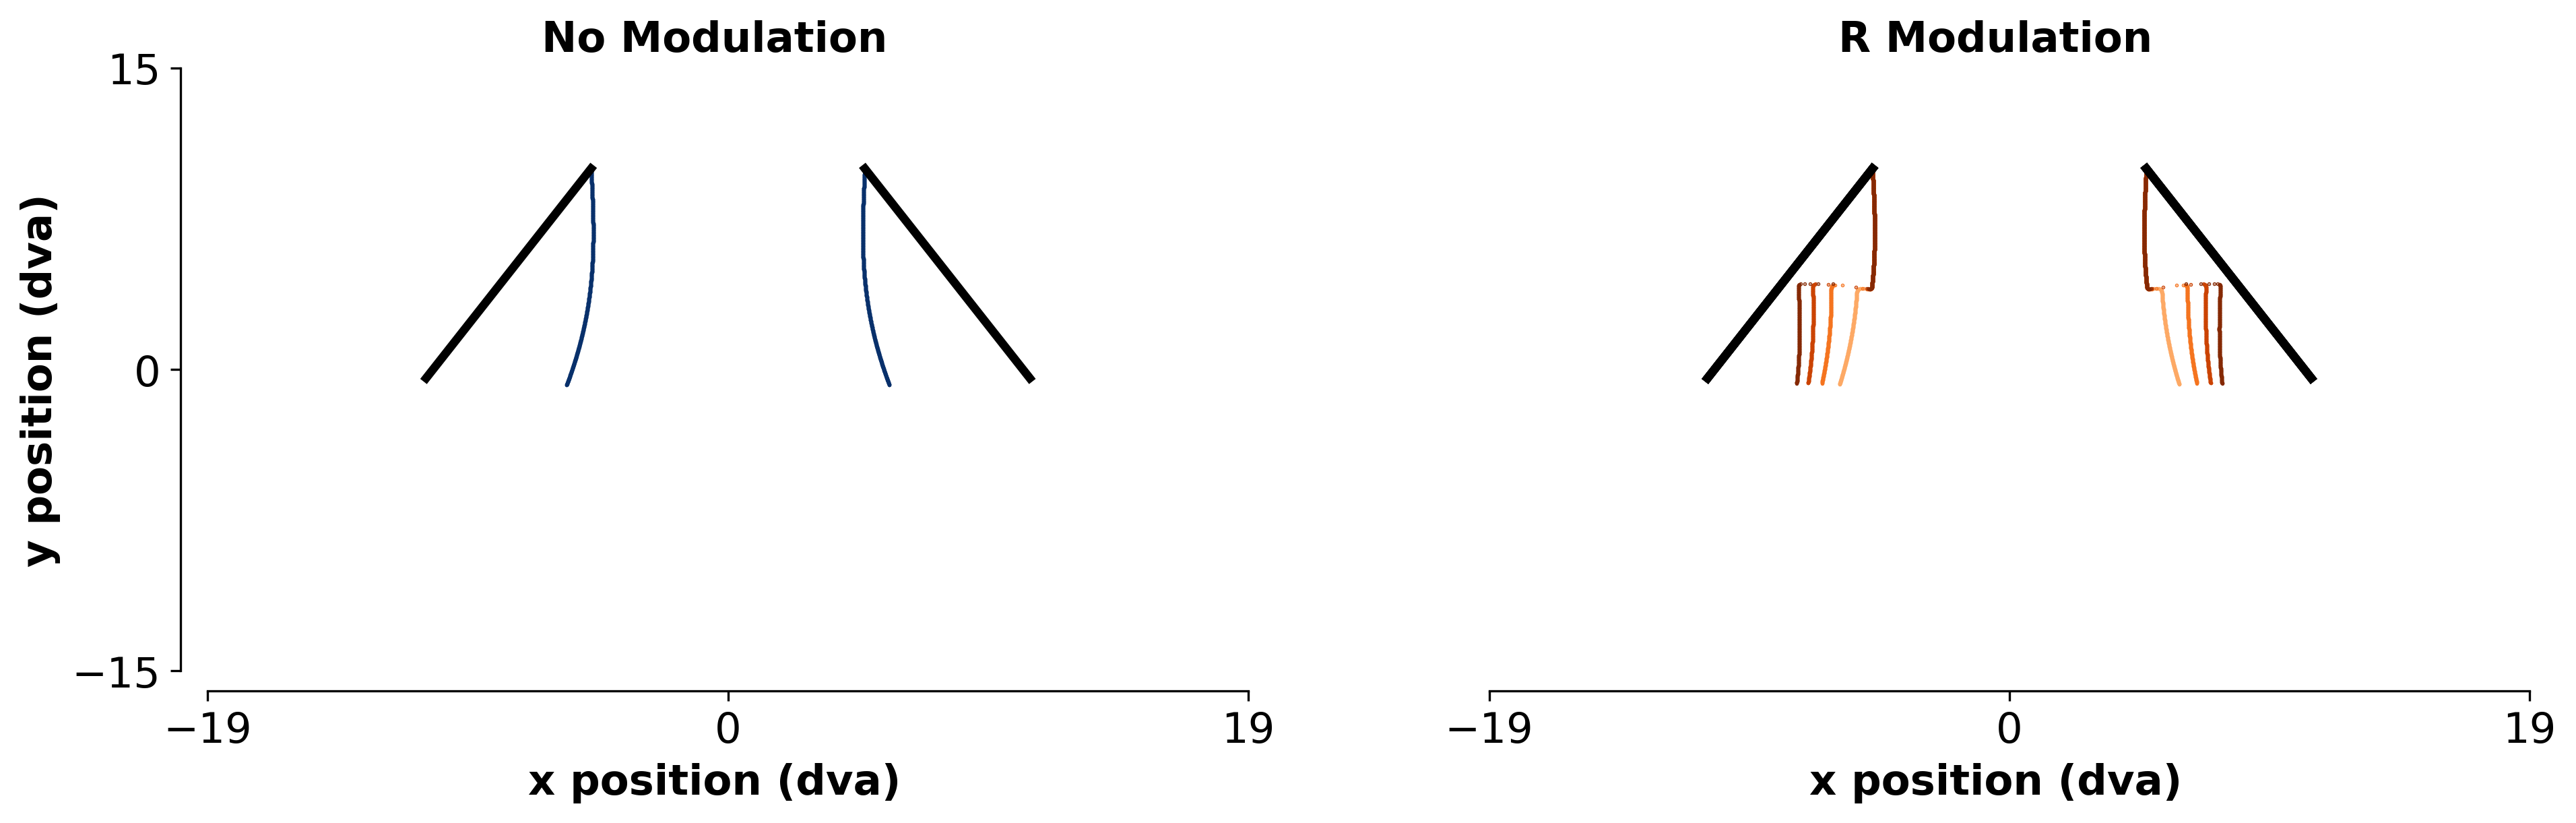

In [6]:
# simulate modulation (transient decrease) of measurement noise (R)

run_sim('R')

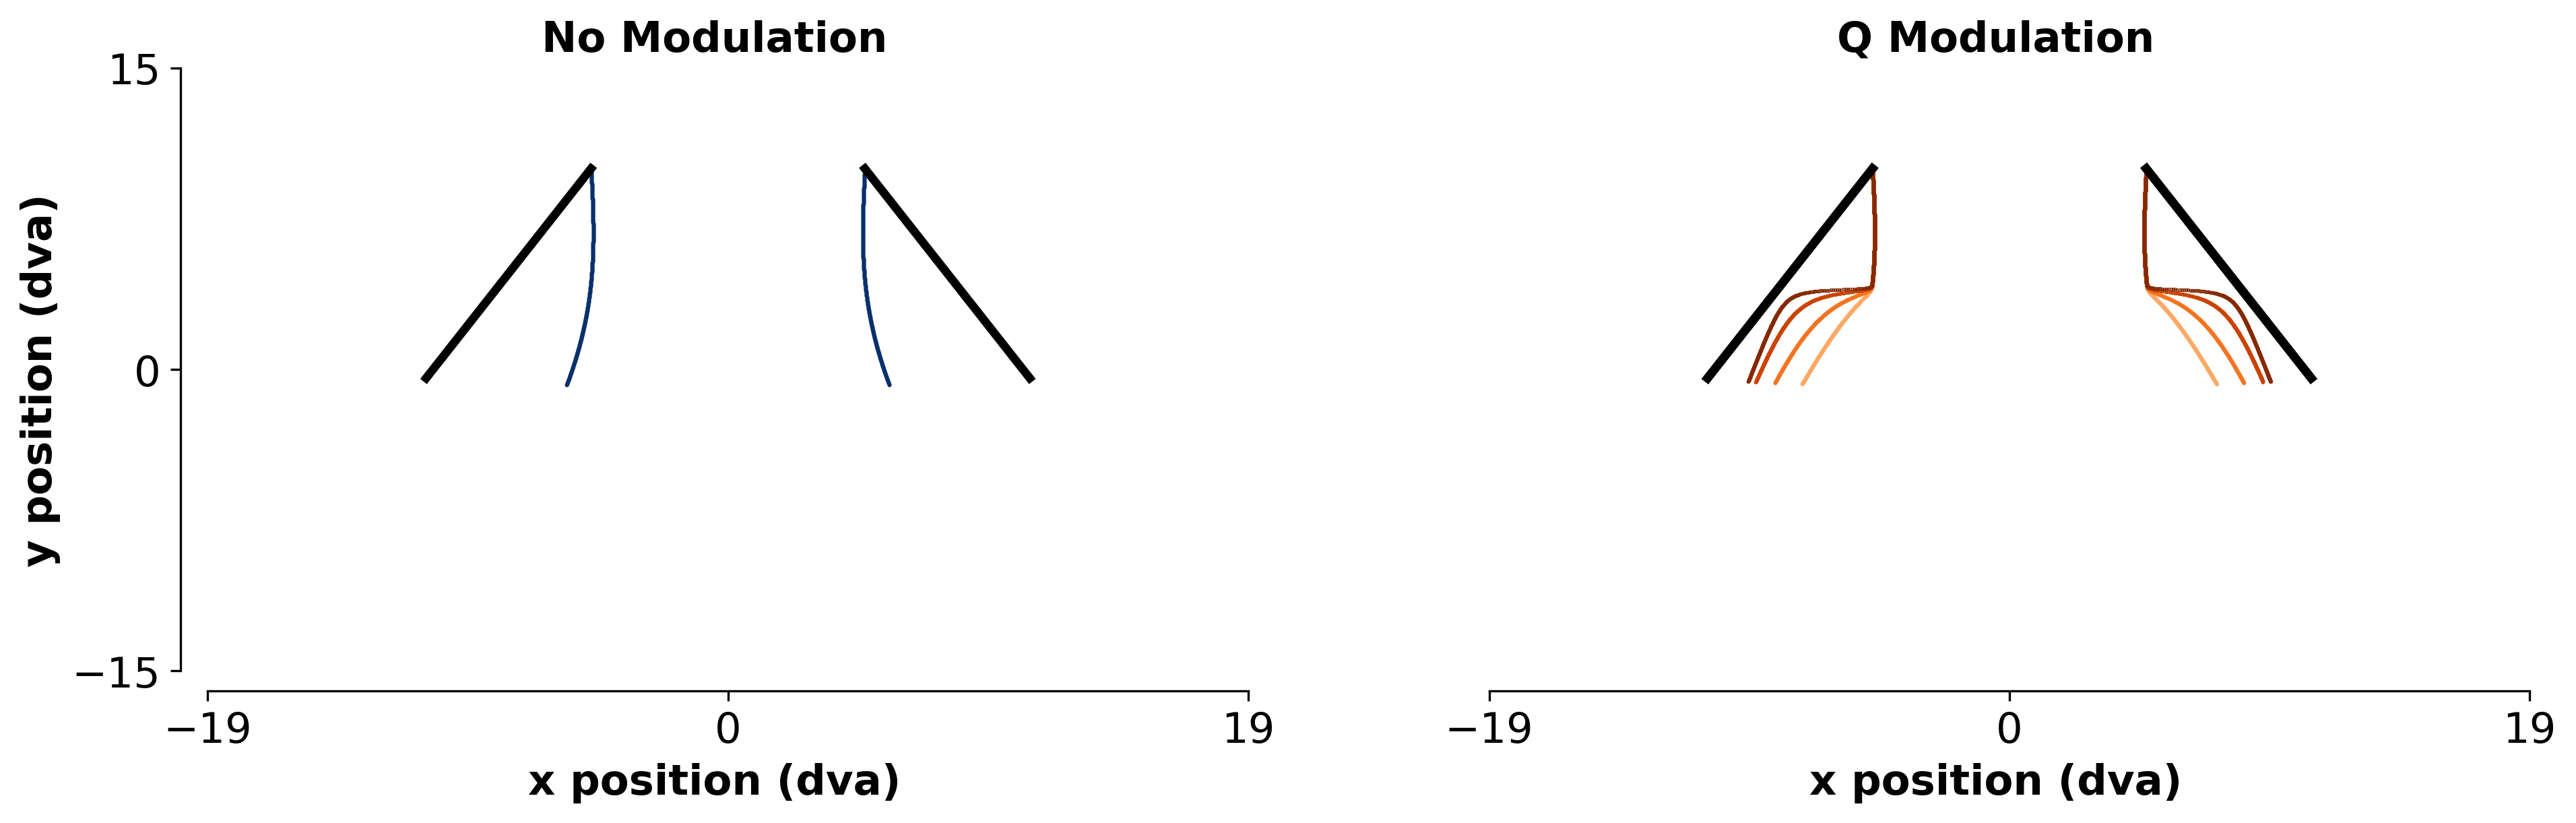

In [7]:
# simulate modulation (transient increase) of process noise (Q)

run_sim('Q')

## Observations 

As expected, both manipulations trigger resets. However, it's interesting to note that they have qualitatively different reset trajectories. In the measurement noise simulation resets are more abrupt, while in the process noise simulation resets are less abrupt and trajectories are more curved. In the present study, we have not quantitatively fit the trajectory estimates as it's likely that the exact shape of hand-drawn trajectories may be additionally influenced by non-perceptual factors (e.g., motoric costs etc). However, future studies may considering use alternative reset measurement approaches (e.g. Liu, Tse and Cavanagh, 2021 - bioRxiv preprint), which may allow more quantitative metrics to be extracted. This may then make it possible to differentiate the competing accounts we have simulated above on the basis of fine-grained difference in reset trajectories. Importantly, studies should also more exhaustively examine whether/how these differences in reset trajectories hold across the entire parameter space. 
